# Speech-based-stress-detection-using-a-cross-modal-transfer-learning-approach: Generating images from audio files

In [1]:
from IPython.display import Audio
import librosa
import glob
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
SAMPLE_RATE = 16000
DIR_AUDIOS = '../data/processed_audios/'

## Reading directory files

In [3]:
files_audios = [(f, (f.split('/')[-1]).split('.')[0]) for f in glob.glob(DIR_AUDIOS + "*.wav")]
print(f'Number audio files: {len(files_audios)}')

Number audio files: 32


## Selecting an example file

In [4]:
example_file = files_audios[2]
example_file

('../data/processed_audios/ID_852630991_baseline.wav', 'ID_852630991_baseline')

## Loading an audio file

In [5]:
y, sample_rate = librosa.load(example_file[0], sr=SAMPLE_RATE)

print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(y)/sample_rate))

Sample Rate   16000 Hz
Clip Length   112.00 seconds


## Plotting audio data

In [6]:
n_sec = 1
clip = y[10*SAMPLE_RATE:(10+n_sec)*SAMPLE_RATE]
clip.shape

(16000,)

## Generating almost squared spectrogram

We check the trade-off between time and frequency resolution. The greater the n_fft, the lower the time resolution.

In [7]:
n_fft = 256 # freq resolution
hop_length = int(n_fft/2)
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

In [8]:
data = stft_magnitude_db
data.shape

(129, 126)

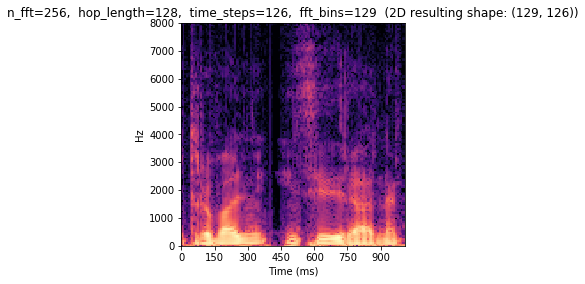

In [9]:
w, h = plt.figaspect(data.shape[0]/data.shape[1])
fig = plt.figure(figsize=(w, h))

librosa.display.specshow(data, x_axis='ms', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)


title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       data.shape[1], 
                       data.shape[0], 
                       data.shape));

In [10]:
## Adjust image dimensions to square
cropped_data = data[0:126,:]

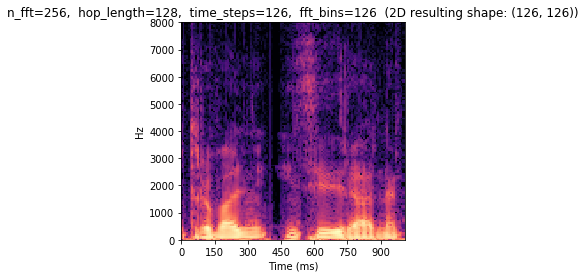

In [11]:
w, h = plt.figaspect(cropped_data.shape[0]/cropped_data.shape[1])
fig = plt.figure(figsize=(w, h))

librosa.display.specshow(cropped_data, x_axis='ms', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)


title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       cropped_data.shape[1], 
                       cropped_data.shape[0], 
                       cropped_data.shape));

## Generating the melspectrogram

In [12]:
n_sec = 1
clip = y[10*SAMPLE_RATE:(10+n_sec)*SAMPLE_RATE]
clip.shape

(16000,)

In [13]:
n_mels = 63  # number of Mel bands to generate
n_fft = 512 # freq resolution
hop_length = int(n_fft/2)

fmin = 50           
fmax = sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)

mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
print(mel_spec_db.shape)

(63, 63)


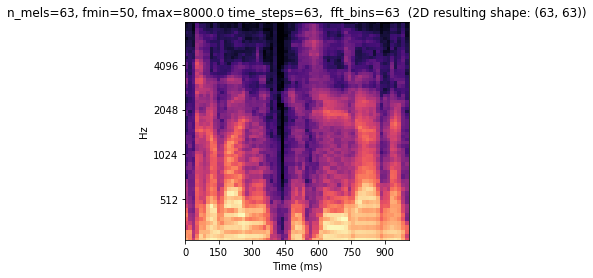

In [14]:
w, h = plt.figaspect(mel_spec_db.shape[0]/mel_spec_db.shape[1])
fig = plt.figure(figsize=(w, h))


librosa.display.specshow(mel_spec_db, x_axis='ms',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax)

title = 'n_mels={}, fmin={}, fmax={} time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_mels, fmin, fmax, mel_spec_db.shape[1], mel_spec_db.shape[0], mel_spec_db.shape));


## Saving an image for training the model

In [15]:
from PIL import Image

def matrix_2_RGB_image(x, filename, show=False):
    # Normalization between (0,1) range
    xmax, xmin = x.max(), x.min()
    x_norm = (x - xmin)/(xmax - xmin)
    
    im = Image.fromarray(np.uint8(plt.cm.inferno(x_norm)*255)).convert('RGB')
    im.save(filename)
    
    if show:
        im.show()

In [16]:
x = mel_spec_db
filename = 'demo.png'
matrix_2_RGB_image(x, filename)

## Loading the image to check dimensions

In [17]:
def load_image_2_array(filename):
    im = Image.open(filename)
    array = np.array(im)
    return array

In [18]:
data_im = load_image_2_array(filename)
data_im.shape

(63, 63, 3)